## Part 1: Pulse Rate Algorithm

### Contents
Fill out this notebook as part of your final project submission.

**You will have to complete both the Code and Project Write-up sections.**
- The [Code](#Code) is where you will write a **pulse rate algorithm** and already includes the starter code.
   - Imports - These are the imports needed for Part 1 of the final project. 
     - [glob](https://docs.python.org/3/library/glob.html)
     - [numpy](https://numpy.org/)
     - [scipy](https://www.scipy.org/)
- The [Project Write-up](#Project-Write-up) to describe why you wrote the algorithm for the specific case.


### Dataset
You will be using the **Troika**[1] dataset to build your algorithm. Find the dataset under `datasets/troika/training_data`. The `README` in that folder will tell you how to interpret the data. The starter code contains a function to help load these files.

Each dataset with the similar name 'DATA_01_TYPE01' contains a variable 'sig'. It has 6 rows. The first row is a simultaneous recording of ECG, which is recorded from the chest of each subject. The
second row and the third row are two channels of PPG, which are recorded from the wrist of each
subject. The last three rows are simultaneous recordings of acceleration data (in x-, y-, and z-axis).

During data recording, each subject ran on a treadmill with changing speeds. For datasets with
names containing 'TYPE01', the running speeds changed as follows:

rest(30s) -> 8km/h(1min) -> 15km/h(1min) -> 8km/h(1min) -> 15km/h(1min) -> rest(30s)

For datasets with names containing 'TYPE02', the running speeds changed as follows: 

rest(30s) -> 6km/h(1min) -> 12km/h(1min) -> 6km/h(1min) -> 12km/h(1min) -> rest(30s)

For each dataset with the similar name 'DATA_01_TYPE01', the ground-truth of heart rate can be
calculated from the simultaneously recorded ECG signal (i.e. the first row of the variable 'sig'). 

For convenience, we also provide the calculated ground-truth heart rate, stored in the datasets with the corresponding name, say 'REF_01_TYPE01'. In each of this kind of datasets, there is a variable 'BPM0', which gives the BPM value in every 8-second time window. Note that two successive time windows overlap by 6 seconds. Thus the first value in 'BPM0' gives the calcualted heart rate ground-truth in the first 8 seconds, while the second value in 'BPM0' gives the calculated heart rate ground-truth from the 3rd second to the 10th second.


1. Zhilin Zhang, Zhouyue Pi, Benyuan Liu, ‘‘TROIKA: A General Framework for Heart Rate Monitoring Using Wrist-Type Photoplethysmographic Signals During Intensive Physical Exercise,’’IEEE Trans. on Biomedical Engineering, vol. 62, no. 2, pp. 522-531, February 2015. Link

-----

### Code

In [58]:
import glob

import numpy as np
import scipy as sp
import scipy.io
import pandas as pd

In [374]:
def LoadTroikaDataset():
    """
    Retrieve the .mat filenames for the troika dataset.

    Review the README in ./datasets/troika/ to understand the organization of the .mat files.

    Returns:
        data_fls: Names of the .mat files that contain signal data
        ref_fls: Names of the .mat files that contain reference data
        <data_fls> and <ref_fls> are ordered correspondingly, so that ref_fls[5] is the 
            reference data for data_fls[5], etc...
    """
    data_dir = "./datasets/troika/training_data"
    data_fls = sorted(glob.glob(data_dir + "/DATA_*.mat"))
    ref_fls = sorted(glob.glob(data_dir + "/REF_*.mat"))
    return data_fls, ref_fls

def LoadTroikaDataFile(data_fl):
    """
    Loads and extracts signals from a troika data file.

    Usage:
        data_fls, ref_fls = LoadTroikaDataset()
        ppg, accx, accy, accz = LoadTroikaDataFile(data_fls[0])

    Args:
        data_fl: (str) filepath to a troika .mat file.

    Returns:
        numpy arrays for ppg, accx, accy, accz signals.
    """
    data = sp.io.loadmat(data_fl)['sig']
    return data[2:]

def LoadTroikaRefFile(ref_fl):
    """
    Loads and extracts ground truth pulse rate measured from ECG from a troika reference data file.

    Usage:
        data_fls, ref_fls = LoadTroikaDataset()
        ref = LoadTroikaDataFile(data_fls[0])

    Args:
        ref_fl: (str) filepath to a troika .mat file.

    Returns:
        numpy arrays for heart rate measured through ECG signals.
    """
    data = sp.io.loadmat(ref_fl)['BPM0']
    return data


def AggregateErrorMetric(pr_errors, confidence_est):
    """
    Computes an aggregate error metric based on confidence estimates.

    Computes the MAE at 90% availability. 

    Args:
        pr_errors: a numpy array of errors between pulse rate estimates and corresponding 
            reference heart rates.
        confidence_est: a numpy array of confidence estimates for each pulse rate
            error.

    Returns:
        the MAE at 90% availability
    """
    # Higher confidence means a better estimate. The best 90% of the estimates
    #    are above the 10th percentile confidence.
    percentile90_confidence = np.percentile(confidence_est, 10)

    # Find the errors of the best pulse rate estimates
    best_estimates = pr_errors[confidence_est >= percentile90_confidence]

    # Return the mean absolute error
    return np.mean(np.abs(best_estimates))

def Evaluate():
    """
    Top-level function evaluation function.

    Runs the pulse rate algorithm on the Troika dataset and returns an aggregate error metric.

    Returns:
        Pulse rate error on the Troika dataset. See AggregateErrorMetric.
    """
    # Retrieve dataset files
    data_fls, ref_fls = LoadTroikaDataset()
    errs, confs = [], []
    for data_fl, ref_fl in zip(data_fls, ref_fls):
        # Run the pulse rate algorithm on each trial in the dataset
        errors, confidence = RunPulseRateAlgorithm(data_fl, ref_fl)
        errs.append(errors)
        confs.append(confidence)
        # Compute aggregate error metric
    errs = np.hstack(errs)
    confs = np.hstack(confs)
    return AggregateErrorMetric(errs, confs)

def BandpassFilter(signal, pass_band, fs):
    """
    Butterworth bandpass filter algorithm.
    
    Returns:
        Bandpass filtered signal
    """          
    b, a = sp.signal.butter(2, pass_band, btype='bandpass', fs = fs)
    return sp.signal.filtfilt(b, a, signal)

def FourierTransform(signal, fs): 
    """
    Runs Fourier Transform on given signal

    Returns: 
        frequency and magnitude of the given signal
    """
    
    # Take an FFT of the signal. If the signal is too short, 0-pad it so we have at least 2046 points in the FFT.
    fft_len = max(len(signal), 2046)
    
    # Create an array of frequency bins
    freqs = np.fft.rfftfreq(fft_len, 1 / fs)
    
    # Take an FFT of the centered signal
    fft = np.fft.rfft(signal - np.mean(signal), fft_len)
    
    return freqs, np.abs(fft)

def PreprocessSignal(signal, fs): 
    # Apply bandpass filter
    bp_filtered_signal = BandpassFilter(signal, pass_band, fs)
    
    # Apply Fourier Transform
    freqs, fft = FourierTransform(bp_filtered_signal, fs)

    # Remove unwanted frequencies
    fft[freqs <= 40/60] = 0.0
    fft[freqs >= 240/60] = 0.0
    
    return freqs, fft

def Featurize(ppg, accx, accy, accz, fs, verbose=False):   
    """
    Create features from the data
    
    Returns:
        PPG and ACC features
    """
    features = []

    # Preprocess PPG np
    ppg_freqs, ppg_fft = PreprocessSignal(ppg, fs)
    
    if verbose: 
        plt.clf()
        plt.subplots(1,2,figsize=(10,5))

        plt.subplot(121)
        plt.plot(ppg_freqs, ppg_fft)
        plt.title('PPG')
        plt.xlabel('Frequency (Hz)')
        
    # Preprocess ACC signal
    acc = np.sqrt(accx**2 + accy**2 + accz**2)
    acc_freqs, ppg_fft = PreprocessSignal(acc, fs)
    
    if verbose: 
        plt.subplot(122)
        plt.plot(acc_freqs, acc_fft)
        plt.title('ACC')
        plt.xlabel('Frequency (Hz)')
        
    # Find PPG peak frequency
    ppg_peaks_ix, ppg_peaks_properties = find_peaks(ppg_fft, height=3000)
    ppg_peaks = zip(ppg_peaks_ix, ppg_peaks_properties['peak_heights'])
    print('ppg_peaks:', ppg_peaks_ix, ppg_peaks_properties['peak_heights'])
    
    ppg_peaks_sorted = sorted(ppg_peaks, key=lambda x: x[1], reverse=True)
    print('ppg_peaks_sorted:', ppg_peaks_sorted)
    
    acc_peaks_ix, acc_peaks_properties = find_peaks(acc_fft, height=40)
    acc_peaks = zip(acc_peaks_ix, acc_peaks_properties['peak_heights'])
    acc_peaks_sorted = sorted(acc_peaks, key=lambda x: x[1], reverse=True)
    print('acc_peaks_sorted:', acc_peaks_sorted)
    
    # When the dominant accelerometer frequency is the same as the PPG, try picking the 
    # next strongest PPG frequency if there is another good candidate.
    # Sometimes the cadence of the arm swing is the same as the heart beat. 
    # If there is no other good candidate pulse rate outside of the accelerometer peak, 
    # it may be the same as the accelerometer.

    ppg_pk_i, ppg_pk_height = ppg_peaks_sorted[0]
    acc_pk_i, acc_pk_height = acc_peaks_sorted[0]
    if len(ppg_peaks_sorted) > 1 and ppg_pk_height == acc_pk_height: 
        ppg_pk_i, ppg_pk_height = ppg_peaks_sorted[1]

    # add to feature
    features.append(ppg_freqs[ppg_pk_i])
    features.append(acc_freqs[acc_pk_i])
    
    # print
    if verbose: 
       
        plt.subplots(1,2,figsize=(10,5))
        # PPG
        plt.subplot(121)
        plt.plot(ppg_freqs, ppg_fft)
        plt.title('PPG')
        plt.xlabel('Frequency (Hz)')

        # plot all ppg peaks
        for i, height in ppg_peaks_sorted: 
            print('plot ppg peak at i={}, height={}'.format(ppg_freqs[i], height))
            plt.plot(ppg_freqs[i], height, "x")
        
        # plot selected ppg peak
        print('selected ppg peak at i={}, height={}'.format(ppg_pk_i, ppg_pk_height))
        plt.plot(ppg_freqs[ppg_pk_i], ppg_pk_height, "o")
        
         
        # ACC
        plt.subplot(122)
        plt.plot(acc_freqs, acc_fft)
        plt.title('ACC')
        plt.xlabel('Frequency (Hz)')
        # plot selected ppg peak
        print('selected acc peak at i={}, height={}'.format(acc_pk_i, acc_pk_height))
        plt.plot(acc_freqs[acc_pk_i], acc_pk_height, "o")

        
    return np.array(features)

def RunPulseRateAlgorithm(data_fl, ref_fl):
    # Load data using LoadTroikaDataFile
    ppg, accx, accy, accz = LoadTroikaDataFile(data_fl)

    # Compute pulse rate estimates and estimation confidence.

    # Return per-estimate mean absolute error and confidence as a 2-tuple of numpy arrays.
    errors, confidence = np.ones(100), np.ones(100)  # Dummy placeholders. Remove
    return errors, confidence

In [375]:
def Regression():       
    """
    Train Regressor model
    
    Returns:
        Trained model
    """ 

    # Constants
    fs = 125
    window_size_sec = 8
    window_overlap_sec = 6
    window_shift_sec = window_size_sec-window_overlap_sec 
    window_size = window_size_sec*fs
    window_shift = window_shift_sec*fs
    pass_band = (40/60, 240/60)
    
    features, labels, ppg_signals = [], [], []
    
    # Load filenames
    data_fls, ref_fls = LoadTroikaDataset()
    
    # Load & process data to generate features
    for data_fl, ref_fl in zip(data_fls, ref_fls):
        # Load data using LoadTroikaDataFile
        ppg, accx, accy, accz = LoadTroikaDataFile(data_fl)
        ref = LoadTroikaRefFile(ref_fl)
        
        # Segment signals through rolling windows        
        n_windows = min(len(ref), len(ppg))
        window_start_indexes, window_end_indexes = generateRollingWindows(n_windows, window_size, window_shift)
        
        # Generate features for signals within each window
        for start, end in zip(windows_start_indexes, window_end_indexes): 
            ppg_w = ppg[start:end]
            accx_w = accx[start:end]
            accy_w = accy[start:end]
            accz_w = accz[start:end]
            label = ref[start]
            
            ppg_signals.append(PreprocessSignal(ppg_w, fs))
            features_w = Featurize(ppg_w, accx_w, accy_w, accz_w, fs, verbose=True)   
            features.append(features_w)
            labels.append(label)
    
    features, labels = np.array(features), np.array(labels)
    
    model = RandomForestRegressor(n_estimators = 400, max_depth = 20)
    cv = KFold(n_splits=5)
    
    y_tests = []
    y_preds = []
    for train_ind, test_ind in cv.split(features, labels):
        X_train, y_train = features[train_ind], labels[train_ind]
        X_test, y_test = features[test_ind], labels[test_ind]

        # Train model
        model.fit(X_train, y_train)
        
        # Predict
        y_pred = model.predict(X_test)
        
        # Aggregate results
        y_tests.append(y_test)
        y_preds.append(y_pred)
        
        # Calculate confidence & error
        ppg_freqs, ppg_fft = PreprocessSignal(ppg_signal[train_ind], fs)
        confid, err = CalcConfidence(y_pred, y_test, ppg_freqs, ppg_fft)
        print('estimated pulse rate={}, true heart rate={}, confid={}, err={}'.format(
        y_predict, y_test, confid, err))
    
    return model

ppg_peaks: [] []
ppg_peaks_sorted: []
acc_peaks_sorted: [(43, 60.09383545621454), (64, 50.62724867231424), (61, 43.02096384888992), (28, 40.822575772051)]


IndexError: list index out of range

<Figure size 640x480 with 0 Axes>

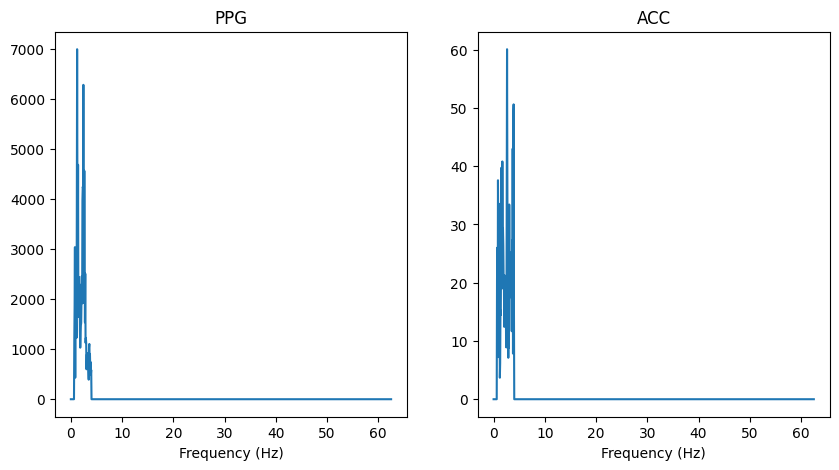

In [376]:
Regression()

## EDA

In [119]:
data_fls, ref_fls = LoadTroikaDataset()
data_fls[:2]

['./datasets/troika/training_data/DATA_01_TYPE01.mat',
 './datasets/troika/training_data/DATA_02_TYPE02.mat']

In [123]:
ppg, accx, accy, accz = LoadTroikaDataFile(data_fls[0])
print(len(ppg))
print(len(accx))
print('total {:0.2f} min of data'.format(len(accx)/125/60))

37937
37937
total 5.06 min of data


In [128]:
ref = LoadTroikaRefFile(ref_fls[0])
print(len(ref))

148


In [191]:
def generateRollingWindows(n_windows, window_size, window_shift):
    """
    Generate rolling windows with specified window size and shift. 

    Return the start (inclusive) and end (exclusive) indexes for each window. 
    """
    window_start_indexes = ((np.cumsum(np.ones(n_windows))-1)*window_shift).astype(int)
    window_end_indexes = (window_start_indexes + window_size).astype(int)
    return window_start_indexes, window_end_indexes

n_windows = min(len(ref), ppg.shape[0])
window_start_indexes, window_end_indexes = generateRollingWindows(n_windows, window_size, window_shift)

In [193]:
i = 0
for start, end in zip(windows_start_indexes, window_end_indexes): 
    print ("start={}, end={}".format(start, end))
    i += 1
    if i > 5:
        break   

start=0, end=1000
start=250, end=1250
start=500, end=1500
start=750, end=1750
start=1000, end=2000
start=1250, end=2250


## single window

In [196]:
# get a single window data in PPG and accelerameter. 
window = 30
start = window_start_indexes[window]
end = window_end_indexes[window]
print('window [{}:{}]'.format(start,end))
ppg_30 = ppg[start:end]
accx_30 = accx[start:end]
accy_30 = accy[start:end]
accz_30 = accz[start:end]


print(len(ppg_30))
print(len(accx_30))
print(len(accy_30))
print(len(accz_30))

window [7500:8500]
1000
1000
1000
1000


In [343]:
label = ref[window].item() #BPM
label

75.33482142857142

In [242]:
# generate features
pass_band = (40/60, 240/60)
# 1. bandpass filter
bp_filtered_ppg_30 = BandpassFilter(ppg_30, pass_band, fs)
bp_filtered_accx_30 = BandpassFilter(accx_30, pass_band, fs)
bp_filtered_accy_30 = BandpassFilter(accy_30, pass_band, fs)
bp_filtered_accz_30 = BandpassFilter(accz_30, pass_band, fs)
bp_filtered_acc_30 = np.sqrt(bp_filtered_accx_30**2 + bp_filtered_accy_30**2 + bp_filtered_accz_30**2)

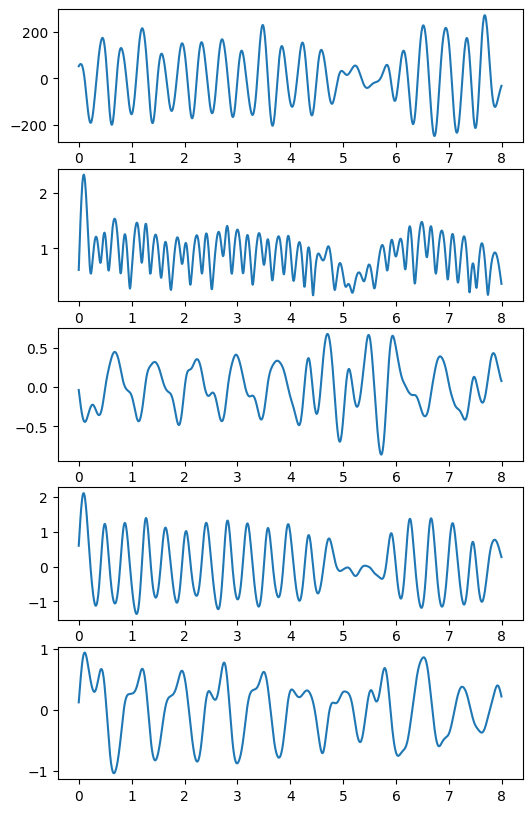

In [246]:
# plot in time-domain 
ts = np.arange(len(ppg_30))/fs
_, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(5,1, figsize=(6, 10))
ax1.plot(ts, bp_filtered_ppg_30)
ax2.plot(ts, bp_filtered_acc_30)
ax3.plot(ts, bp_filtered_accx_30)
ax4.plot(ts, bp_filtered_accy_30)
ax5.plot(ts, bp_filtered_accz_30)

ax1.set_title='ppg'
ax2.set_title='acc'
ax3.set_title='accx'
ax4.set_title='accy'
ax5.set_title='accz'

In [279]:
# 2. fourier transform & find peak
# a. PPG
ppg_freqs, ppg_fft = FourierTransform(bp_filtered_ppg_30, fs)
ppg_fft[ppg_freqs <= 40/60] = 0.0
ppg_fft[ppg_freqs >= 240/60] = 0.0
ppg_peak = ppg_freqs[np.argmax(ppg_fft)]
print('PPG Dominant frequency is at {:0.4f} Hz'.format(ppg_peak))

PPG Dominant frequency is at 2.6271 Hz


2.6270772238514173 69107.6505323458


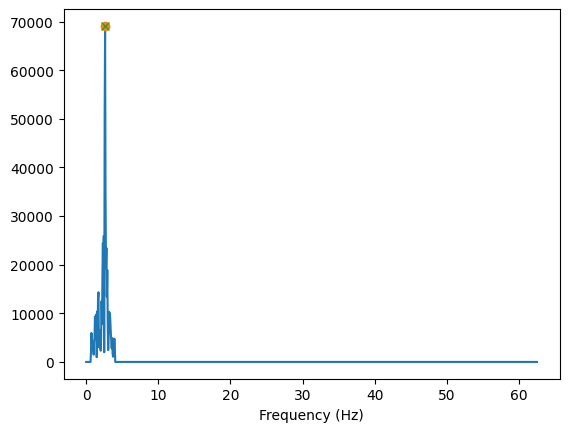

In [302]:

ppg_peaks_ix, ppg_peaks_properties = find_peaks(ppg_fft, height=30000)
ppg_peaks = zip(ppg_peaks_ix, ppg_peaks_properties['peak_heights'])
ppg_peaks_sorted = sorted(ppg_peaks, key=lambda x: x[1])

plt.clf()
plt.plot(ppg_freqs, ppg_fft)
plt.xlabel('Frequency (Hz)')
plt.plot(ppg_peak, ppg_fft[np.argmax(ppg_fft)], "o")

for i, height in ppg_peaks_sorted: 
    print(ppg_freqs[i], height)
    plt.plot(ppg_freqs[i], height, "x")

In [292]:
# 2. fourier transform & find peak
# b. ACC xyz
acc_freqs, acc_fft = FourierTransform(bp_filtered_acc, fs)
acc_fft[acc_freqs <= 40/60] = 0.0
acc_fft[acc_freqs >= 240/60] = 0.0
acc_peak_fft_i = np.argmax(acc_fft)
acc_peak = acc_freqs[acc_peak_fft_i]
acc_peak_fft = np.abs(acc_fft[acc_peak_fft_i])
print('ACC Peak at {} Hz'.format(acc_peak))

ACC Peak at 2.6270772238514173 Hz


1.7106549364613879 40.822575772051
3.7267839687194524 43.02096384888992
3.910068426197458 50.62724867231424
2.6270772238514173 60.09383545621454


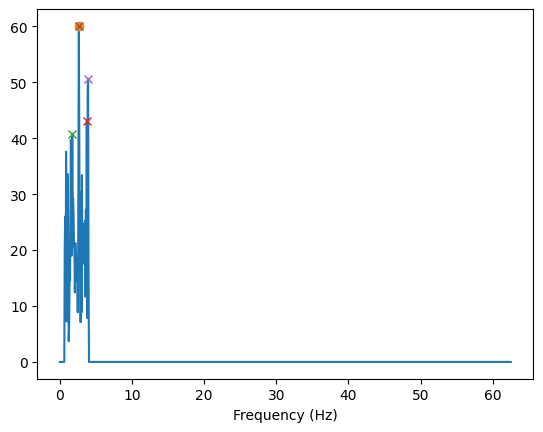

In [304]:
plt.clf()
acc_peaks_ix, acc_peaks_properties = find_peaks(acc_fft, height=40)
acc_peaks = zip(acc_peaks_ix, acc_peaks_properties['peak_heights'])
acc_peaks_sorted = sorted(acc_peaks, key=lambda x: x[1])

plt.clf()
plt.plot(acc_freqs, acc_fft)
plt.xlabel('Frequency (Hz)')
plt.plot(acc_peak, acc_fft[np.argmax(acc_fft)], "o")

for i, height in acc_peaks_sorted: 
    print(acc_freqs[i], height)
    plt.plot(acc_freqs[i], height, "x")

In [305]:
# When the dominant accelerometer frequency is the same as the PPG, try picking the next strongest PPG frequency if there is another good candidate.
# Sometimes the cadence of the arm swing is the same as the heart beat. So if you can't find another good candidate pulse rate outside of the accelerometer peak, it may be the same as the accelerometer.
ppg_peak_selected = ppg_peaks_sorted[0]
if len(ppg_peaks_sorted) > 1 and ppg_peaks_sorted[0] == acc_peaks_sorted[0]: 
    ppg_peak_selected = ppg_peaks_sorted[1]

plot ppg peak at i=2.6270772238514173, height=69107.6505323458
selected ppg peak at i=43, height=69107.6505323458
selected acc peak at i=43, height=60.09383545621454


array([2.62707722, 2.62707722])

<Figure size 640x480 with 0 Axes>

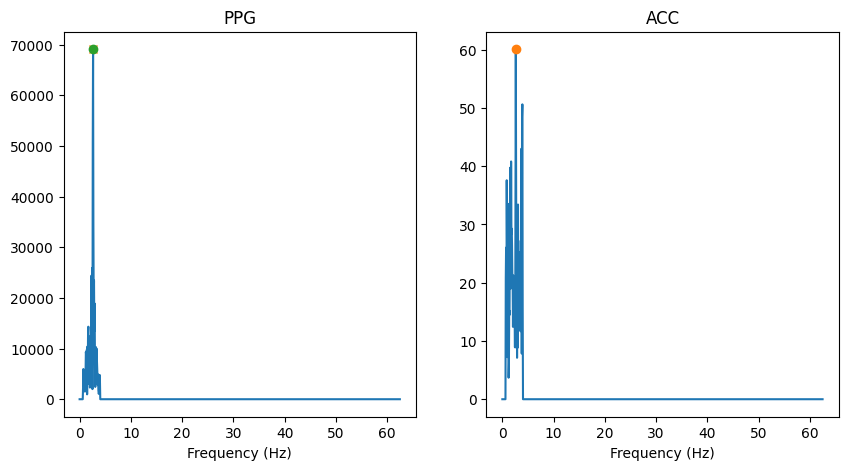

In [331]:
features = Featurize(ppg_30, accx_30, accy_30, accz_30, fs, verbose=True)   
features

In [345]:
def CalcConfidence(predicted_freq, label, ppg_freqs, ppg_fft):
    '''Calculates a confidence value for a given frequency by computing
       the ratio of energy concentrated near that frequency compared to the full signal.
       Parameters:
           predicted_freq: frequency prediction for heart rate.
           freqs: full list of FFT frequency bins
           fft_ppg: FFT of normalized PPG signal
       
       Returns:
           conf_val: Confidence value for heart rate prediction.
    '''
    
    bpm_sum_window = 10 # Hyperparameter that can be tuned. Currently 10 BPM
    bps_sum_window = bpm_sum_window/60 # Conversion 1 Hz = 1 per minute * (1 min/60 s)
        
    confidences = []
    for i in range(filt_ppg_specs.shape[1]):
        window = (ppg_freqs>=predicted_freq-bps_sum_window) & (ppg_freqs<=predicted_freq+bps_sum_window)
        ppg_fft = np.abs(ppg_fft)
        confidence = np.sum(ppg_fft[window])/np.sum(ppg_fft)
        error = np.abs(predicted_freq-label/60)
        
    return confidence, error

In [379]:


def RunPulseRateAlgorithm(data_fl, ref_fl):
    """
    Runs algorithm to estimate Pulse rate.
    
    Usage:
        errors, confidence = RunPulseRateAlgorithm(data_fl, ref_fl)
        
    Args:
       data_fl: (str) filepath to a troika .mat file with ECG, PPG, and ACC measurement data.
       ref_fl: (str) filepath to a troika .mat file with ref pulse rate.
       
    Returns:
        errors: a numpy array of errors between pulse rate estimates and corresponding reference heart rates.
        confidence: a numpy array of confidence estimates for each pulse rate.
    
    """
    # Load data using LoadTroikaDataFile
    ppg, accx, accy, accz = LoadTroikaDataFile(data_fl)

    # Compute pulse rate estimates and estimation confidence.
    
    #Load PPG and Accelerometer Signals.  Get Freqs and FFT Spectra for PPG and Accelerometer signals.
    fs=125
    nfft_window = fs*8
    noverlap = fs*6
    
    filtered_ppg = BandpassFilter(ppg, pass_band, fs)
    filt_ppg_specs, filt_ppg_freqs,_,filt_ppg_im = plt.specgram(filtered_ppg, NFFT = nfft_window, Fs=fs, noverlap=noverlap)
    plt.close()
    
    filtered_accx = BandpassFilter(accx, pass_band, fs)
    accx_specs, accx_freqs,_,_ = plt.specgram(filtered_accx, NFFT = nfft_window, Fs=fs, noverlap=noverlap)
    plt.close()
    
    filtered_accy = BandpassFilter(accy, pass_band, fs)
    accy_specs, accy_freqs,_,_ = plt.specgram(filtered_accy, NFFT = nfft_window, Fs=fs, noverlap=noverlap)
    plt.close()
    
    filtered_accz = BandpassFilter(accz, pass_band, fs)
    accz_specs, accz_freqs,_,_ = plt.specgram(filtered_accz, NFFT = nfft_window, Fs=fs, noverlap=noverlap)
    plt.close()
      
    """
    Compute pulse Rate Estimates.  
    distance_bpm is the maximum distance between Accelerometers (x,y,and z) frequency and PPG frequency 
        that will be considered to be too similar. This can occur if arm movements have strong contribution
        to PPG signals.
    distance_bps converts the distance_bpm from per minute to per second(Hz).
    Compare up to 10 PPG frequencies that potentially represent the pulse rate to find one that is not 
    similar to accx, accy, or accz.  
    If none found, select the frequency with largest magnitude.
    """
    
    ppg_max_freqs = []
    distance_bpm = 10 # Hyperparameter that was tested from 5 BPM to 20 BPM
    distance_bps = distance_bpm/60 # Conversion 1 Hz = 1 cycles per minute * (1 min/60 s)
    count=0
    inner=0
    for i in range(filt_ppg_specs.shape[1]):
        accx_max_freq = accx_freqs[np.argmax(accx_specs[:,i])]
        accy_max_freq = accy_freqs[np.argmax(accy_specs[:,i])]
        accz_max_freq = accz_freqs[np.argmax(accz_specs[:,i])]
        sorted_ppg_specs = np.sort(filt_ppg_specs[:,i])[::-1]
        count += 1
        #for f in range(filt_ppg_specs.shape[0]):
        for f in range(10):
            ppg_freq = filt_ppg_freqs[np.argwhere(filt_ppg_specs == (sorted_ppg_specs[f]))[0][0]]
            inner+=1
            if ppg_freq == 0:
                continue
            elif (np.abs(ppg_freq-accx_max_freq)<=distance_bps) or (np.abs(ppg_freq-accy_max_freq)<=distance_bps) or (np.abs(ppg_freq-accz_max_freq)<=distance_bps):
                #if f == (filt_ppg_specs.shape[0]-1):
                if f == 9:
                    ppg_max_freqs.append(filt_ppg_freqs[np.argwhere(filt_ppg_specs == (sorted_ppg_specs[0]))[0][0]])
                continue
            else:
                ppg_max_freqs.append(ppg_freq)
                break
    #print(f'Count: {count}, Inner: {inner}, ppg_max_freqs: {len(ppg_max_freqs)}')            

    
    """
    Compute Confidence Estimation:
    - For this computation, The energy in the frequency spectrum that is concentrated near the pulse rate estimate is
    determined by summing the frequency spectrum around the pulse rate estimate with a window of bpm_sum_window.
    - The bpm_sum_window will be chosen to be less than the performance criterion of 15BPM difference 
    between estimated pulse rate and reference pulse rate.
    - The Confidence Estimate is the Energy around the Pulse Rate Estimate divided by the sum of the 
    entire frequency spectrum.
    """
    
    bpm_sum_window = 10 # Hyperparameter that can be tuned. Currently 10 BPM
    bps_sum_window = bpm_sum_window/60 # Conversion 1 Hz = 1 per minute * (1 min/60 s)
    
    ecgdata = sp.io.loadmat(ref_fl)['BPM0']
    
    confidences = []
    for i in range(filt_ppg_specs.shape[1]):
        low_window = ppg_max_freqs[i]-bps_sum_window 
        high_window = ppg_max_freqs[i] + bps_sum_window
        window = (filt_ppg_freqs>= low_window) & (filt_ppg_freqs<=high_window)
        confidence=np.sum(filt_ppg_specs[:,i][window])/np.sum(filt_ppg_specs[:,i])
        error = np.abs(ppg_max_freqs[i]*60-ecgdata[i][0])
        confidences.append((i, ppg_max_freqs[i]*60, ecgdata[i][0], confidence, error))

    confidence_df = pd.DataFrame(
                    data=confidences, 
                    columns=['WindowNumber','Estimated_Pulse_Rate','Ref_BPM','Confidence','Error'])
    
    # Return per-estimate mean absolute error and confidence as a 2-tuple of numpy arrays.
  
    errors = confidence_df['Error'].values
    confidence = confidence_df['Confidence'].values
    
    return errors, confidence

In [380]:
Evaluate()

10.720090095500963

-----
### Project Write-up

Answer the following prompts to demonstrate understanding of the algorithm you wrote for this specific context.

> - **Code Description** - Include details so someone unfamiliar with your project will know how to run your code and use your algorithm. 
> - **Data Description** - Describe the dataset that was used to train and test the algorithm. Include its short-comings and what data would be required to build a more complete dataset.
> - **Algorithhm Description** will include the following:
>   - how the algorithm works
>   - the specific aspects of the physiology that it takes advantage of
>   - a describtion of the algorithm outputs
>   - caveats on algorithm outputs 
>   - common failure modes
> - **Algorithm Performance** - Detail how performance was computed (eg. using cross-validation or train-test split) and what metrics were optimized for. Include error metrics that would be relevant to users of your algorithm. Caveat your performance numbers by acknowledging how generalizable they may or may not be on different datasets.

Your write-up goes here...

-----
### Next Steps
You will now go to **Test Your Algorithm** (back in the Project Classroom) to apply a unit test to confirm that your algorithm met the success criteria. 